In [47]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from copy import deepcopy

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure

In [48]:
lens = SampleStrongLens()
roman = Roman()

band = 'F106'
scene_size = 5  # arcsec
oversample = 5
config = {'sca': 1,
          'sca_position': (2048, 2048)}

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens SAMPLE by Roman in F106 band


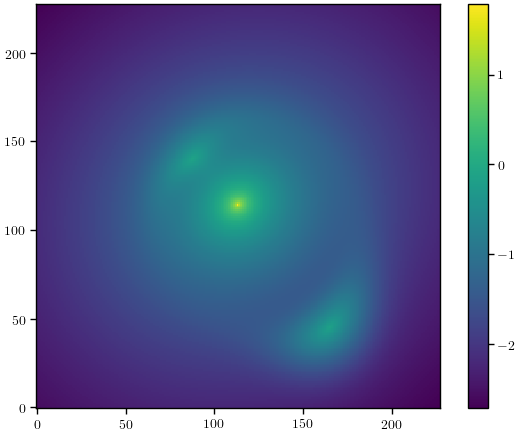

In [49]:
synth = SyntheticImage(lens, roman, band=band, arcsec=scene_size, oversample=oversample, **config)

plt.imshow(np.log10(synth.image))
plt.colorbar()
plt.show()

In [50]:
print(synth.pixel_scale)
print(synth.num_pix)
print(synth.arcsec)
print(synth.image.shape)

0.022
228
5.016
(228, 228)


In [51]:
print(synth.num_pix / synth.oversample)

45.6


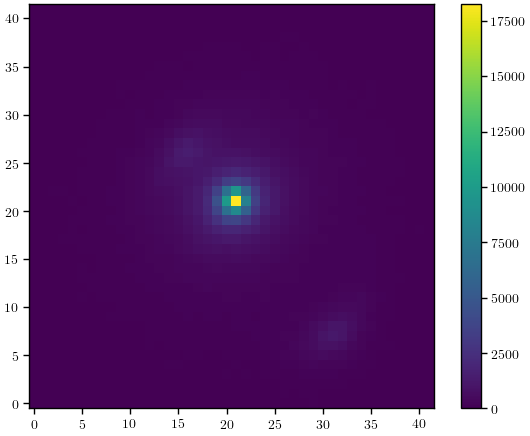

In [52]:
exposure = Exposure(synth, exposure_time=146, **config)

plt.imshow(exposure.exposure)
plt.colorbar()
plt.show()

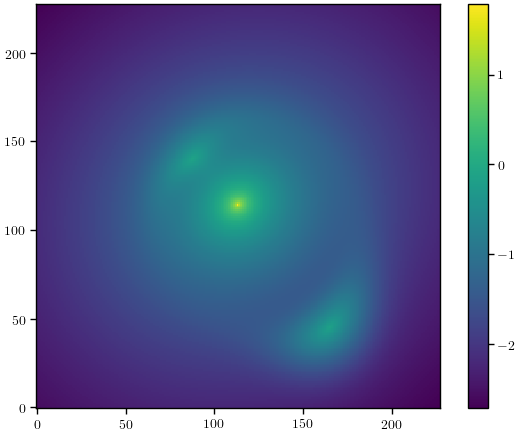

In [53]:
zp = roman.get_zeropoint_magnitude(band, config['sca'])
array = lens.get_array(num_pix=228, side=5.016, band=band, zp=zp)

plt.imshow(np.log10(array))
plt.colorbar()
plt.show()

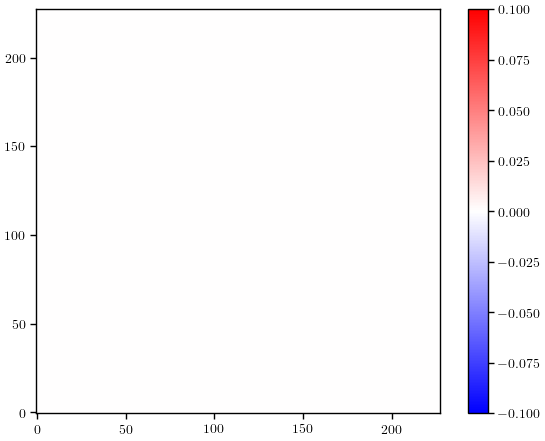

In [54]:
plt.imshow(synth.image - array, cmap='bwr')
plt.colorbar()
plt.show()

assert np.array_equal(synth.image, array), 'Arrays are not equal'

In [55]:
gs_results, _ = gs.get_images(lens, [array], [band], roman.zp_dict['SCA01'], input_size=51, output_size=42, grid_oversample=oversample, psf_oversample=5, detector=config['sca'], detector_pos=config['sca_position'], exposure_time=146, psf_cache_dir='/data/bwedig/mejiro/cached_psfs', validate=False)
gs_image = gs_results[0] * 146

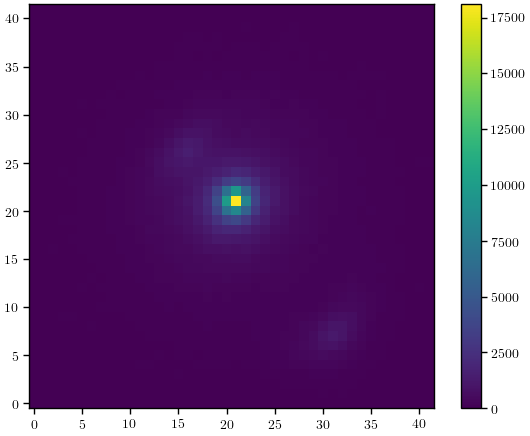

In [56]:
plt.imshow(gs_image)
plt.colorbar()
plt.show()

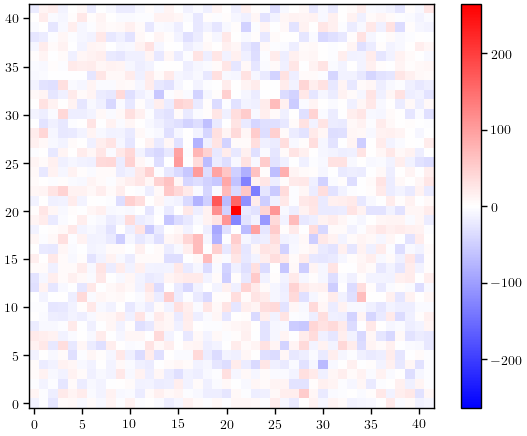

In [57]:
vmax = np.abs(np.max(exposure.exposure - gs_image))
plt.imshow(exposure.exposure - gs_image, cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens SAMPLE by Roman in F106 band


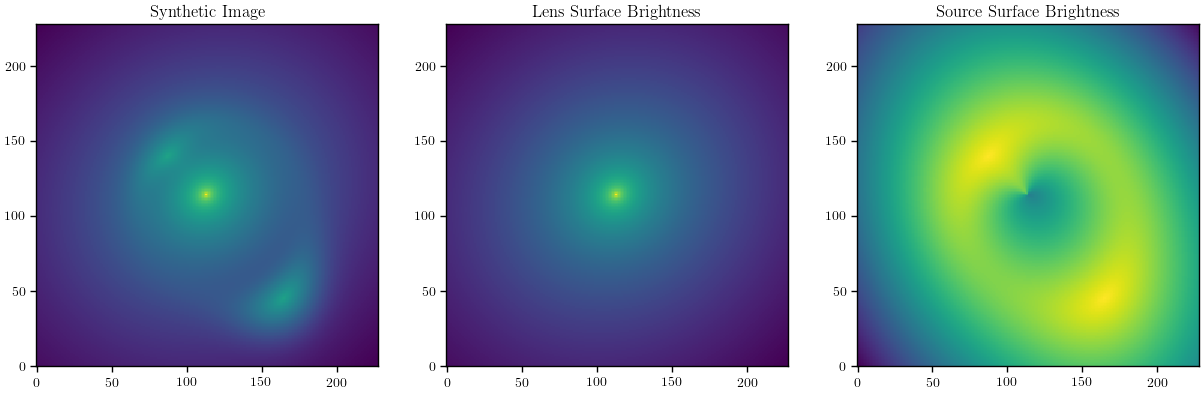

In [58]:
synth = SyntheticImage(lens, roman, band=band, arcsec=scene_size, oversample=oversample, pieces=True, **config)

_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.log10(synth.image))
ax[0].set_title('Synthetic Image')
ax[1].imshow(np.log10(synth.lens_surface_brightness))
ax[1].set_title('Lens Surface Brightness')
ax[2].imshow(np.log10(synth.source_surface_brightness))
ax[2].set_title('Source Surface Brightness')
plt.show()

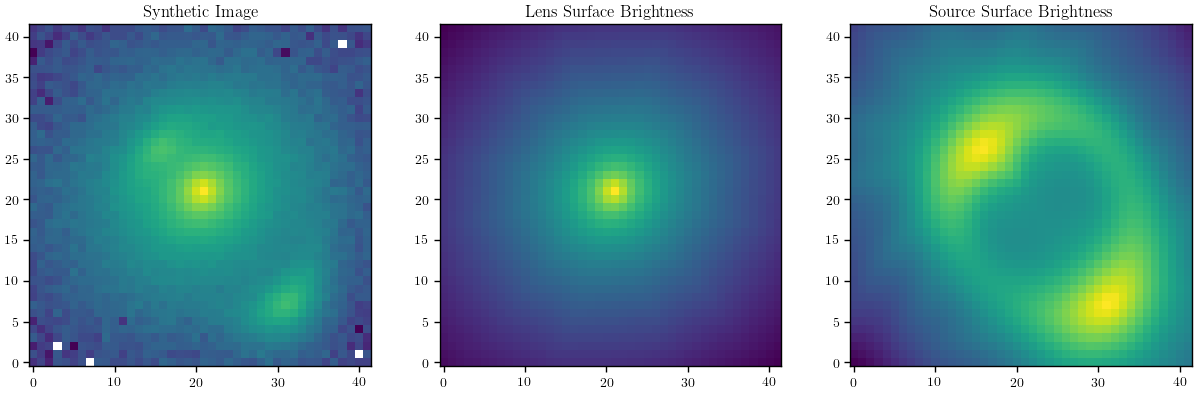

In [59]:
exposure = Exposure(synth, exposure_time=146, **config)

_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.log10(exposure.exposure))
ax[0].set_title('Synthetic Image')
ax[1].imshow(np.log10(exposure.lens_exposure))
ax[1].set_title('Lens Surface Brightness')
ax[2].imshow(np.log10(exposure.source_exposure))
ax[2].set_title('Source Surface Brightness')
plt.show()

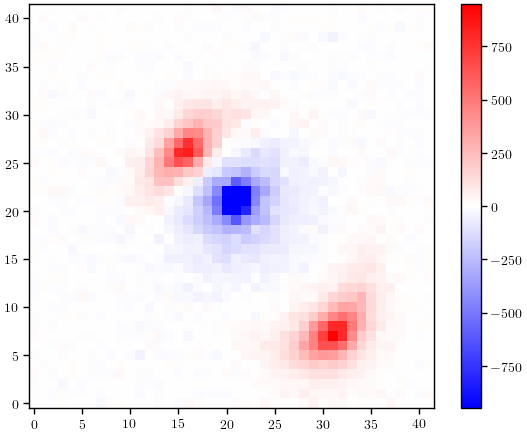

In [60]:
noise = exposure.exposure - (exposure.lens_exposure + exposure.source_exposure)

vmax = np.abs(np.max(noise))
plt.imshow(noise, cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

In [61]:
# generate synthetic images with lenstronomy
model, lens_sb, source_sb = lens.get_array(num_pix=228, side=5.016, band=band, zp=zp, return_pieces=True)

# generate GalSim images
results, lenses, sources, _ = gs.get_images(lens, [array], [band], roman.zp_dict['SCA01'], input_size=51, output_size=42, grid_oversample=oversample, psf_oversample=oversample,
                                            lens_surface_brightness=[lens_sb],
                                            source_surface_brightness=[source_sb], detector=config['sca'], detector_pos=config['sca_position'],
                                            exposure_time=146, validate=False, psf_cache_dir='/data/bwedig/mejiro/cached_psfs')

# put back into units of counts
gs_total = results[0] * 146
gs_lens = lenses[0] * 146
gs_source = sources[0] * 146

# get noise; NB neither lens or source has sky background to detector effects added
gs_noise = gs_total - (gs_lens + gs_source)

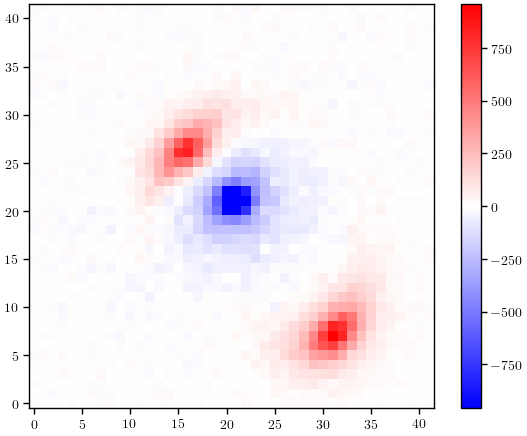

In [68]:
vmax = np.abs(np.max(gs_noise))
plt.imshow(gs_noise, cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

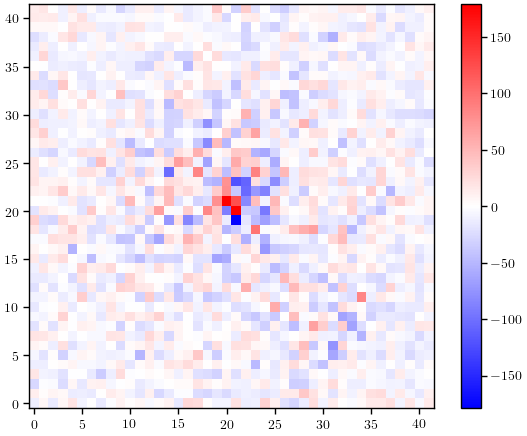

In [69]:
vmax = np.abs(np.max(noise - gs_noise))
plt.imshow(noise - gs_noise, cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

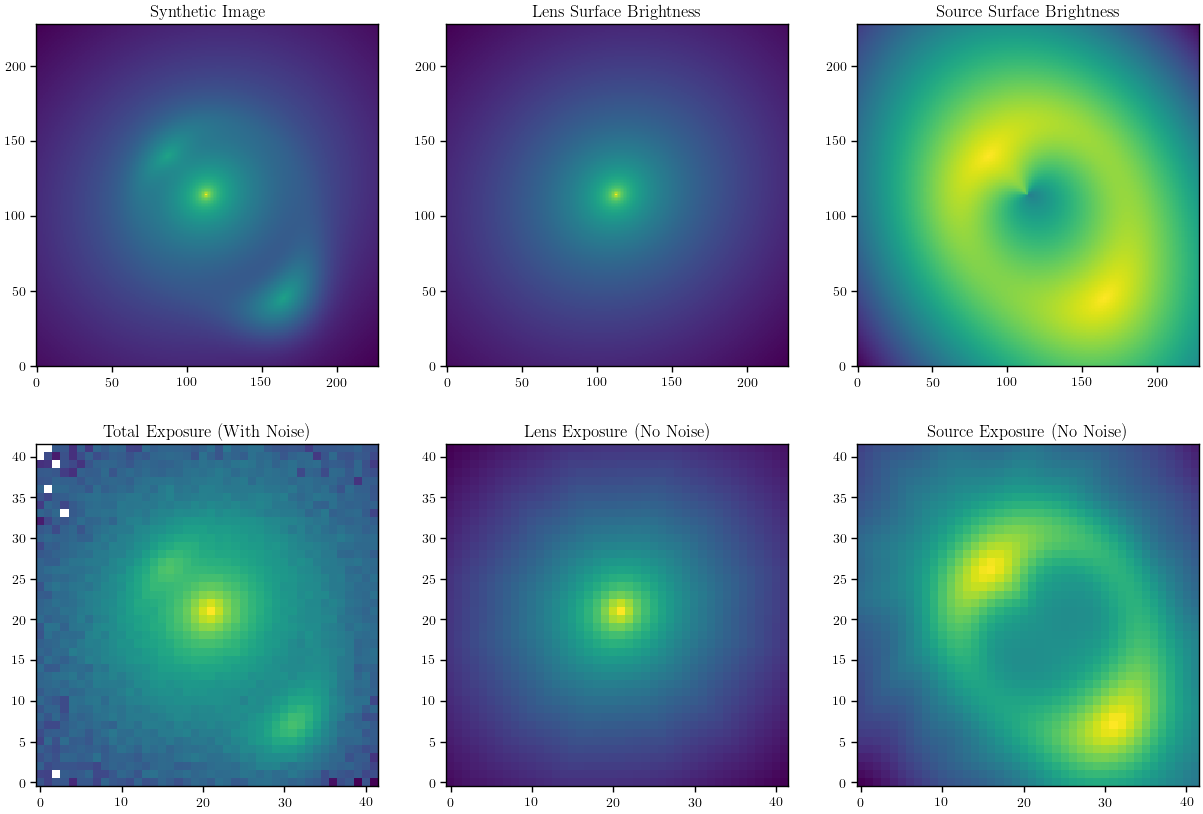

In [62]:
_, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(np.log10(model))
ax[0, 0].set_title('Synthetic Image')
ax[0, 1].imshow(np.log10(lens_sb))
ax[0, 1].set_title('Lens Surface Brightness')
ax[0, 2].imshow(np.log10(source_sb))
ax[0, 2].set_title('Source Surface Brightness')
ax[1, 0].imshow(np.log10(gs_total))
ax[1, 0].set_title('Total Exposure (With Noise)')
ax[1, 1].imshow(np.log10(gs_lens))
ax[1, 1].set_title('Lens Exposure (No Noise)')
ax[1, 2].imshow(np.log10(gs_source))
ax[1, 2].set_title('Source Exposure (No Noise)')
plt.show()

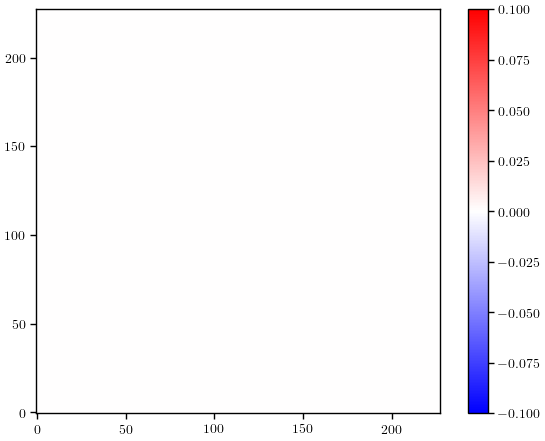

In [64]:
plt.imshow(synth.image - model, cmap='bwr')
plt.colorbar()
plt.show()

# assert np.array_equal(synth.image - model), 'Arrays are not equal'
# assert np.array_equal(synth.lens_surface_brightness - lens_sb), 'Arrays are not equal'
# assert np.array_equal(synth.source_surface_brightness - source_sb), 'Arrays are not equal'

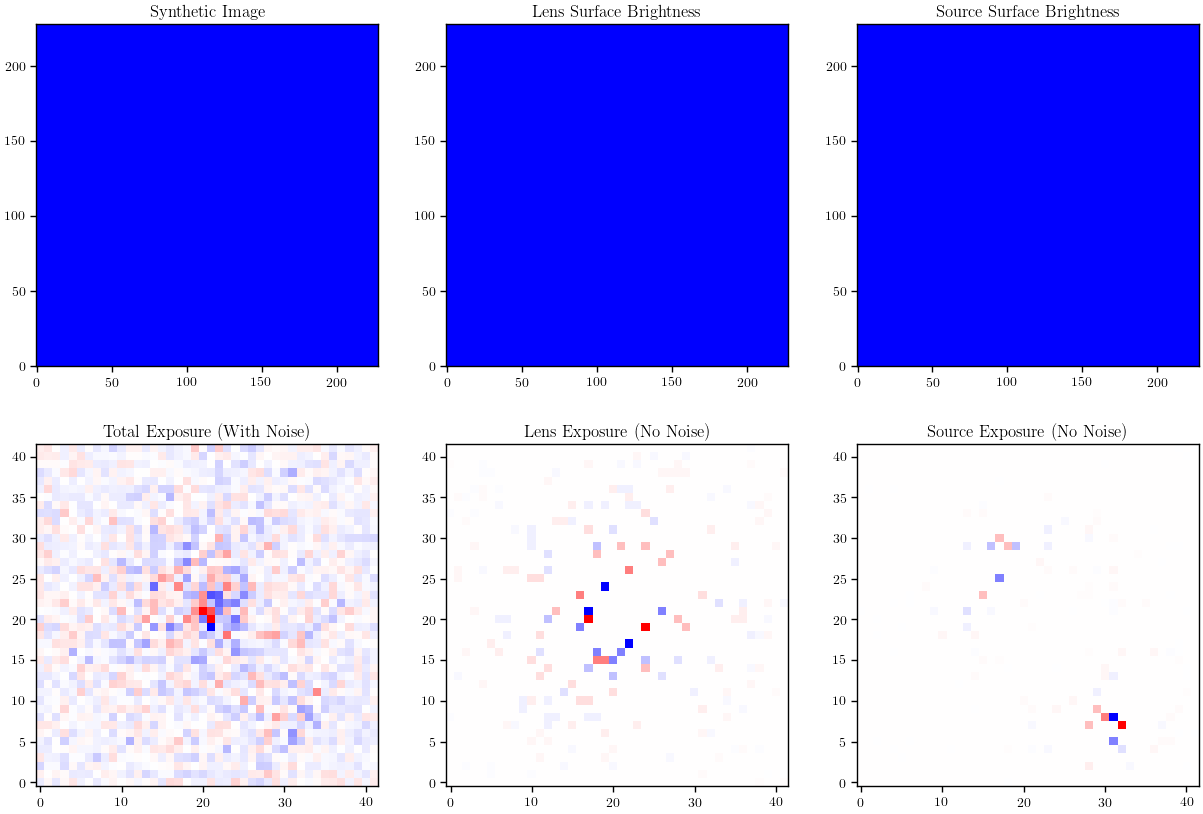

In [65]:
_, ax = plt.subplots(2, 3, figsize=(15, 10))
vmax = np.abs(np.max(synth.image - model))
ax[0, 0].imshow(synth.image - model, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[0, 0].set_title('Synthetic Image')
vmax = np.abs(np.max(synth.lens_surface_brightness - lens_sb))
ax[0, 1].imshow(synth.lens_surface_brightness - lens_sb, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[0, 1].set_title('Lens Surface Brightness')
vmax = np.abs(np.max(synth.source_surface_brightness - source_sb))
ax[0, 2].imshow(synth.source_surface_brightness - source_sb, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[0, 2].set_title('Source Surface Brightness')
ax[1, 0].imshow(exposure.exposure - gs_total, cmap='bwr')
ax[1, 0].set_title('Total Exposure (With Noise)')
ax[1, 1].imshow(exposure.lens_exposure - gs_lens, cmap='bwr')
ax[1, 1].set_title('Lens Exposure (No Noise)')
ax[1, 2].imshow(exposure.source_exposure - gs_source, cmap='bwr')
ax[1, 2].set_title('Source Exposure (No Noise)')
plt.show()

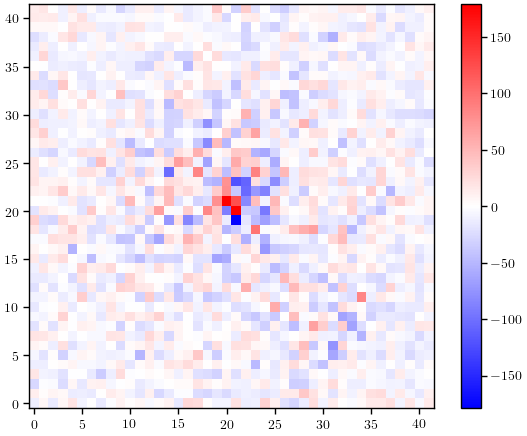

In [67]:
vmax = np.abs(np.max(exposure.exposure - gs_total))
plt.imshow(exposure.exposure - gs_total, cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

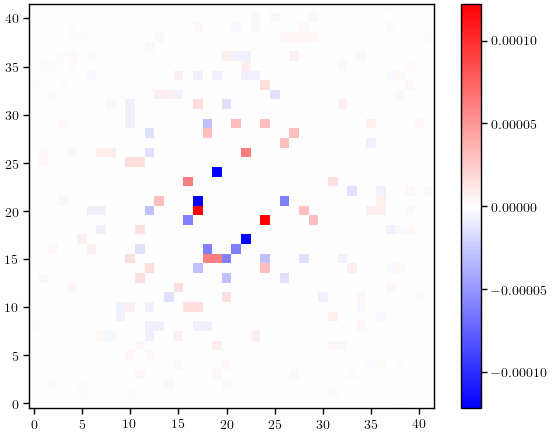

In [66]:
vmax = np.abs(np.max(exposure.lens_exposure - gs_lens))
plt.imshow(exposure.lens_exposure - gs_lens, cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()